# Consolidated Micro Price Data

Daily prices are obtained for the US, Argentina, Brazil, Colombia, and Chile.

Dates: 2007 to 2010.

Data obtained from the Billion Prices Project. Available at the dataverse page for Online Micro Price Data, https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi%3A10.7910%2FDVN%2FIAH6Z6.

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as st
import statsmodels as sm
from scipy.special import factorial
from scipy.optimize import curve_fit
from scipy.stats import chisquare
import warnings
warnings.filterwarnings('ignore')

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = (8, 6)
matplotlib.style.use('ggplot')

In [2]:
# Define lists of datasets and countries

datasets = ["../Data/usa1.dta","../Data/usa2.dta","../Data/argentina.dta","../Data/brazil.dta","../Data/chile.dta","../Data/colombia.dta"]

country = ["USA Supermarket","USA Department Store","Argentina","Brazil","Chile","Colombia"]

# Load the datasets

for (filename,cntry) in zip(datasets,country):
    data = pd.read_stata(filename)
    print(cntry)
    print(data.head())
    print()
       

USA Supermarket
   id  cat_url  bppcat       date  miss  price0  price  nsprice  sale  \
0   1   1968.0     118 2008-05-08   NaN     2.0    2.0      2.0   NaN   
1   1   1968.0     118 2008-05-09   NaN     2.0    2.0      2.0   NaN   
2   1   1968.0     118 2008-05-10   1.0     NaN    NaN      NaN   NaN   
3   1   1968.0     118 2008-05-11   NaN     2.0    2.0      2.0   NaN   
4   1   1968.0     118 2008-05-12   NaN     2.0    2.0      2.0   NaN   

   fullprice  nsfullprice  fullsale  initialspell  lastspell  category  
0        2.0          2.0       NaN           1.0        NaN     118.0  
1        2.0          2.0       NaN           1.0        NaN     118.0  
2        2.0          2.0       NaN           NaN        NaN     118.0  
3        2.0          2.0       NaN           NaN        NaN     118.0  
4        2.0          2.0       NaN           NaN        NaN     118.0  

USA Department Store
   id  cat_url  bppcat       date  miss  price0      price    nsprice  sale  \
0  75 

In [3]:
# NaN check

for (filename,cntry) in zip(datasets,country):
    data = pd.read_stata(filename)
    print(cntry)
    print("Percentage of NaN in the data:\n")
    print(data.isnull().sum()/len(data))
    print()
    
print("\nWe will use 'nsfullprice' as our price data.")


USA Supermarket
Percentage of NaN in the data:

id              0.000000
cat_url         0.000000
bppcat          0.000000
date            0.000000
miss            0.747364
price0          0.252636
price           0.252636
nsprice         0.252636
sale            0.958572
fullprice       0.014395
nsfullprice     0.014395
fullsale        0.911097
initialspell    0.968245
lastspell       0.959472
category        0.000000
dtype: float64

USA Department Store
Percentage of NaN in the data:

id              0.000000
cat_url         0.000000
bppcat          0.000000
date            0.000000
miss            0.621459
price0          0.378541
price           0.378541
nsprice         0.378541
sale            0.998586
fullprice       0.008994
nsfullprice     0.008994
fullsale        0.994519
initialspell    0.954378
lastspell       0.953015
category        0.000000
dtype: float64

Argentina
Percentage of NaN in the data:

id              0.000000
cat_url         0.000000
bppcat          0.000000


In [4]:
# Function restricts dataset to products that have at least 100 days of data

def at_least_n_days(df, n=100):
    """ Use auxiliary dataset to find id's that have at least n days of data. """
    aux = df.groupby(by='id').count()
    aux = aux[aux['nsfullprice'] > n]
    df = df[df.id.isin(aux.index)]
    return df

# Drop outliers. Definition below, following Cavallo (2018)

def drop_outliers(df):
    df = df[df['log_change'] < 2]  # drop price changes > 200%
    df = df[df['log_change'] > -.7]  # drop price changes < -70%
    return df


In [5]:
# Calculate percentage change of prices

def set_log_change_col(df):
    """ Create price 'log_change' column for each product id. """
    df.sort_values(['id', 'date'], inplace=True)
    gb = df.groupby(['id'])['nsfullprice']
    df['log_change'] = gb.transform(lambda x: np.log(x).diff())
    df.sort_index(inplace=True)
    df = drop_outliers(df)
    return df


In [6]:
# Creates positive/negative/neutral price changes 

def create_directions(df):
    df['Positive'] = np.where(df['log_change'] > 0, df['log_change'], None)
    df['Neutral'] = np.where(df['log_change'] == 0, df['log_change'], None)
    df['Negative'] = np.where(df['log_change'] < 0, df['log_change'], None)
    return df

def basic_numbers(df):
    """ Print number of observations for positive, neutral, and negative price changes. 
    And their respective percentages."""
    pos = df[df['log_change']>0]
    neg = df[df['log_change']<0]
    
    p = len(pos)
    n = len(neg)
    total = len(df['log_change'])
    
    print("Number of positive price changes: ", p)
    print("Number of negative price changes: ", n)  
       
    print("Percentage of positive price changes: ", p/(p+n))
    print("Percentage of negative price changes: ", n/(p+n))
    
    return pos, neg

In [7]:
# Function that carries our data analysis for any given country.

def data_analysis(df, country):
         
    # 1. Set data range.
    
    df['date'] = pd.to_datetime(df['date'])
    
    # 2. Restrict dataset to useful variables. Drop NAs
    
    df = df[["date","id","nsfullprice"]]
    df = df.dropna()
      
    # 3. Restrict data to products with at least 100 days of data
    
    df = at_least_n_days(df, n=100)
        
    date_range = df.date.max() - df.date.min()
    n_days = date_range.days
        
    n_products = len(df.id.unique())
    
    # 4. Add percentage log changes, and directions of price change
    
    daily = set_log_change_col(df)  
    basic_pos, basic_neg = basic_numbers(daily)
            
    # Calculate lambda_plus_mu
    n_pos_chgs = len(basic_pos)
    n_pos_prod = len(basic_pos.id.unique())
    
    # create direction columns
    daily = create_directions(daily)
    daily['pos'] = np.where(daily['Positive']>0,1,0)
    daily['pos'] = daily.groupby('date').pos.transform('sum')
    pos_onedays = len(daily[daily['pos']==1].date.unique())
    pos_days = len(daily[daily['pos']>0].date.unique())
    pos_zerodays = len(daily[daily['pos']==0].date.unique())
    print("Number of days with a positive price change", pos_days)
    print("Number of days with zero price changes ", pos_zerodays)

    # 5. Median log price increase
    
    daily_pos = daily[daily['log_change']>0]
    
    print("n_prods_pos", len(daily_pos.id.unique()))
    stats_pos = daily_pos['log_change'].describe()
    print("Median positive price change: ", daily_pos['log_change'].median())

    # 6. Count how many changes in prices per day
    
    gb_date1 = daily.groupby('date')['Positive', 'Neutral', 'Negative'].count()
    
    
    # 7. Define avalanches -- conditional on a price change
 
    gb_date1['Positive_shift'] = gb_date1['Positive'].transform(lambda x: x-1)
    
    #Positive price changes only
    gb_date2 = gb_date1[gb_date1['Positive_shift']>-1]
    
    # Positive price changes histogram
    fig, ax1 = plt.subplots(figsize=(7,5))
    ax1.set_title(country)
    ax1.set_xlabel("Number of positive changes in a day (-1)")
    ax1.set_ylabel("Number of days \n with a given number of positive changes")
    ax1.hist(gb_date2['Positive_shift'], bins=100)
    plt.show()
    
    print(gb_date2['Positive_shift'].describe())
    gb_date2 = gb_date2[gb_date2['Positive_shift']<143]
    fig, ax1 = plt.subplots(figsize=(7,5))
    ax1.set_title(country)
    ax1.set_xlabel("Number of positive changes in a day (-1)")
    ax1.set_ylabel("Number of days \n with a given number of positive changes")
    ax1.hist(gb_date2['Positive_shift'], bins=100)
    fig.savefig("../figs/{}_pricechanges.pdf".format(country), bbox_inches='tight')
    plt.show()
    
    # 8. Moment Estimation Parameters
    
    gb_date1 = gb_date1[gb_date1['Positive_shift']>-1]
    #print(gb_date1['Positive_shift'].describe())
    xbar = gb_date1['Positive_shift'].mean()
    print("Mean/xbar is: ", xbar)

    n = len(gb_date1['Positive_shift'])
    
    print("n is ",n )
    
    ssquare = gb_date1['Positive_shift'].var()
    print("Variance/ssquare: ",ssquare)
    
    theta_tilde = np.sqrt((xbar**3)/ssquare)
    print("Theta_0 moment estimator ", theta_tilde )
    
    lambda_tilde = 1 - np.sqrt(xbar/ssquare)
    print("Theta moment estimator ", lambda_tilde)
    
    var_theta = theta_tilde/(2*n) * (theta_tilde + (2-2*lambda_tilde+3*lambda_tilde**2)/(1-lambda_tilde))
    print("Variance for Theta_0 ", var_theta)
    var_lambda = (1-lambda_tilde)/(2*n*theta_tilde) * (theta_tilde - theta_tilde*lambda_tilde + 2*lambda_tilde + 3*theta_tilde**2)
    print("Variance for Theta ", var_lambda)
    cov_theta_lambda = -1/(2*n) * (theta_tilde*(1-lambda_tilde) + 3*lambda_tilde**2)
    print("Covariance Theta_0-Theta ", cov_theta_lambda)
    stderr_lambda = np.sqrt(var_lambda/n)
    print("Std Error for Theta: ",stderr_lambda)
    stderr_theta = np.sqrt(var_theta/n)
    print("Std Error for Theta0: ", stderr_theta)
    
    # 9. Counter CDF plot
    
    x = np.linspace(1, 142, 142)
    F_x = np.zeros_like(x)

    total = gb_date1['Positive_shift'][gb_date1['Positive_shift']>-1].count()
    for i in range(len(x)):
        F_x[i] = gb_date1['Positive_shift'][gb_date1['Positive_shift'] > x[i]].count() / total
    
    # 9. Fitting a GPD to the counter CDF plot

    def pr(x, a, b):
        pdf = ((a*x + b)**(x-1)) * np.exp(-(a*x + b)) * b / factorial(x)
        pdf0 = (b**(-1)) * np.exp(-b) * b
        ctr_cdf = 1-(np.cumsum(pdf)+pdf0)
        return np.log(ctr_cdf)

    print("Normalized RMSE", (np.sqrt(np.mean((F_x-np.exp(pr(x, lambda_tilde,theta_tilde)))**2)))/np.mean(F_x) )

    print("Optimal values of the parameters:")
    print("theta =", lambda_tilde)
    print("theta0 =", theta_tilde)

    
    fig, ax = plt.subplots(figsize=(7,5))
    ax.plot(np.log(x), np.log(F_x), label="Data")
    ax.plot(np.log(x), pr(x, lambda_tilde, theta_tilde), label="Fit")
    ax.set_ylabel("log(1-F(x))")
    ax.set_xlabel("log(x) Adjusted (-1)")
    ax.legend()
    plt.show()
    fig.savefig("../figs/{}_counter_moment.pdf".format(country), bbox_inches='tight')
    
    return lambda_tilde, theta_tilde, n_days, n_products

   

USA Supermarket
Number of positive price changes:  91795
Number of negative price changes:  76618
Percentage of positive price changes:  0.5450588731273714
Percentage of negative price changes:  0.4549411268726286
Number of days with a positive price change 712
Number of days with zero price changes  102
n_prods_pos 19609
Median positive price change:  0.17898261547088623


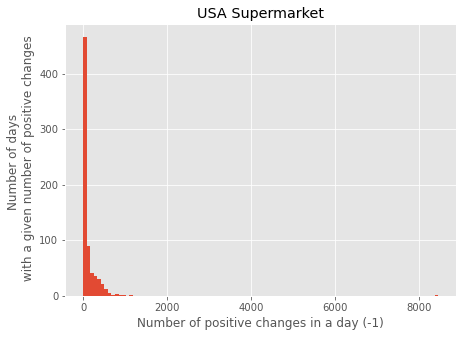

count     712.000000
mean      127.925562
std       352.332751
min         0.000000
25%        18.000000
50%        44.000000
75%       131.500000
max      8453.000000
Name: Positive_shift, dtype: float64


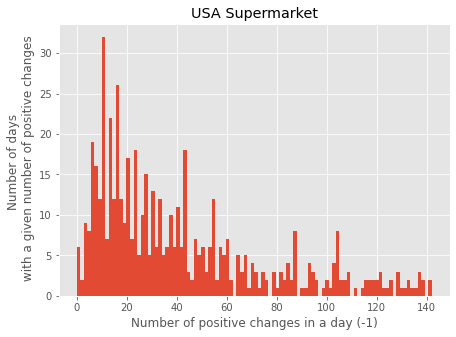

Mean/xbar is:  127.9255617977528
n is  712
Variance/ssquare:  124138.36716564727
Theta_0 moment estimator  4.106605505122683
Theta moment estimator  0.9678984758994834
Variance for Theta_0  0.27009126196225663
Variance for Theta  0.0002890783767086328
Covariance Theta_0-Theta  -0.0020662294062778357
Std Error for Theta:  0.0006371883207117425
Std Error for Theta0:  0.01947669530642581
Normalized RMSE 0.21880765499291147
Optimal values of the parameters:
theta = 0.9678984758994834
theta0 = 4.106605505122683


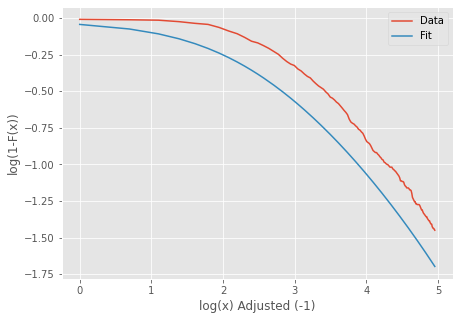


USA Department Store
Number of positive price changes:  24752
Number of negative price changes:  46495
Percentage of positive price changes:  0.3474111190646624
Percentage of negative price changes:  0.6525888809353376
Number of days with a positive price change 688
Number of days with zero price changes  177
n_prods_pos 13514
Median positive price change:  0.1177830696105957


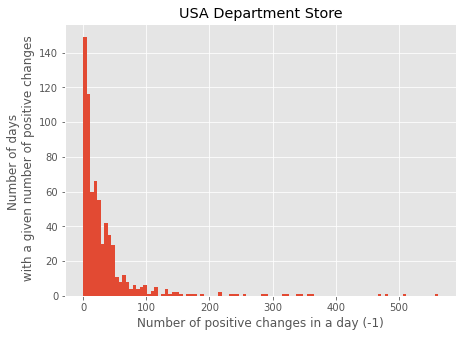

count    688.000000
mean      34.976744
std       60.001111
min        0.000000
25%        7.000000
50%       18.000000
75%       39.000000
max      562.000000
Name: Positive_shift, dtype: float64


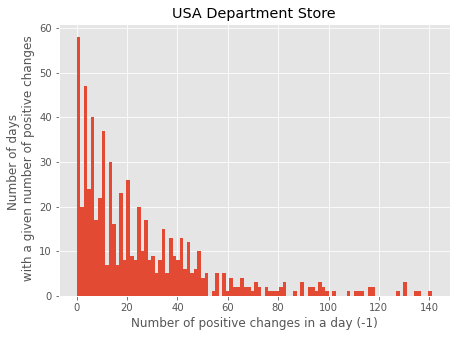

Mean/xbar is:  34.97674418604651
n is  688
Variance/ssquare:  3600.1333739548363
Theta_0 moment estimator  3.4475436680341227
Theta moment estimator  0.9014332594910457
Variance for Theta_0  0.0756141385576791
Variance for Theta  0.0007853921145717464
Covariance Theta_0-Theta  -0.0020185747863883433
Std Error for Theta:  0.0010684373196699864
Std Error for Theta0:  0.010483523794956411
Normalized RMSE 0.14653429969888257
Optimal values of the parameters:
theta = 0.9014332594910457
theta0 = 3.4475436680341227


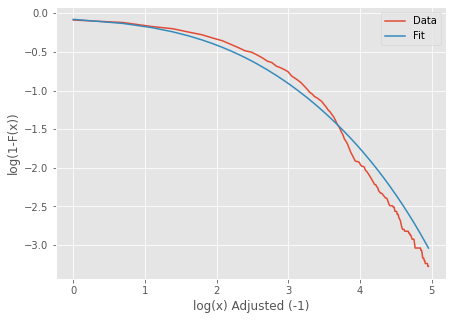


Argentina
Number of positive price changes:  116241
Number of negative price changes:  27809
Percentage of positive price changes:  0.8069489760499826
Percentage of negative price changes:  0.19305102395001736
Number of days with a positive price change 900
Number of days with zero price changes  141
n_prods_pos 20641
Median positive price change:  0.061557769775390625


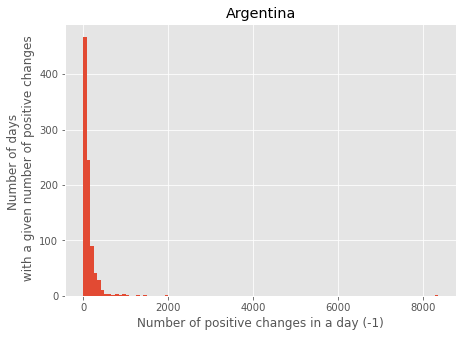

count     900.000000
mean      128.156667
std       314.852892
min         0.000000
25%        30.000000
50%        78.000000
75%       146.250000
max      8358.000000
Name: Positive_shift, dtype: float64


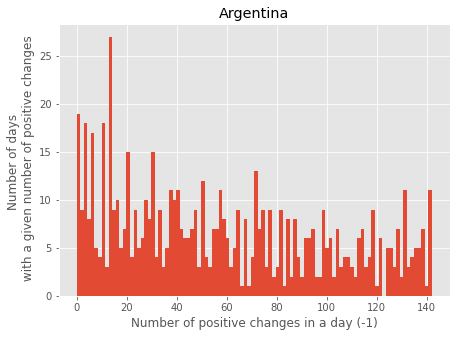

Mean/xbar is:  128.15666666666667
n is  900
Variance/ssquare:  99132.34361512799
Theta_0 moment estimator  4.607911375441333
Theta moment estimator  0.9640447001682212
Variance for Theta_0  0.2154267990263684
Variance for Theta  0.00028520781841324255
Covariance Theta_0-Theta  -0.0016410141038164245
Std Error for Theta:  0.0005629365648229949
Std Error for Theta0:  0.015471364194191093
Normalized RMSE 0.3254764702421187
Optimal values of the parameters:
theta = 0.9640447001682212
theta0 = 4.607911375441333


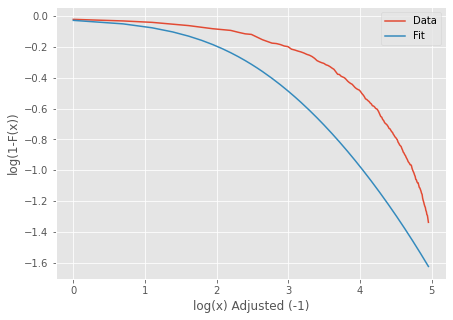


Brazil
Number of positive price changes:  152580
Number of negative price changes:  102952
Percentage of positive price changes:  0.5971072116212451
Percentage of negative price changes:  0.4028927883787549
Number of days with a positive price change 867
Number of days with zero price changes  159
n_prods_pos 19002
Median positive price change:  0.05190777778625488


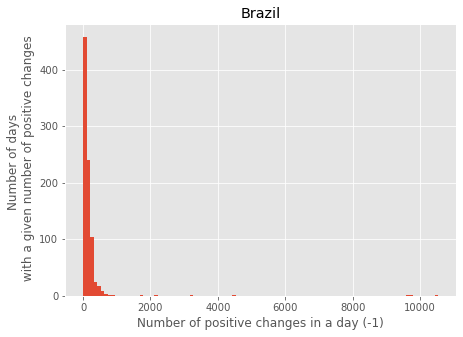

count      867.000000
mean       174.986159
std        625.459380
min          0.000000
25%         41.000000
50%         99.000000
75%        176.500000
max      10538.000000
Name: Positive_shift, dtype: float64


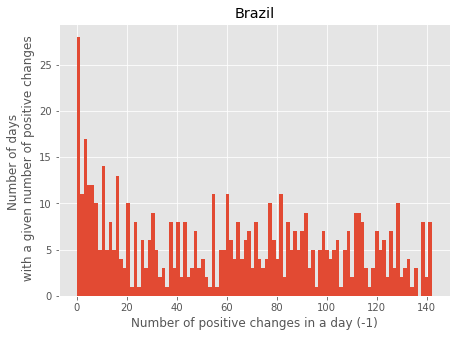

Mean/xbar is:  174.98615916955018
n is  867
Variance/ssquare:  391199.4362978173
Theta_0 moment estimator  3.7008922247753913
Theta moment estimator  0.9788503716960296
Variance for Theta_0  0.30224125106908545
Variance for Theta  0.00014212949126491423
Covariance Theta_0-Theta  -0.0017028354356720993
Std Error for Theta:  0.0004048858059706304
Std Error for Theta0:  0.018670988884253028
Normalized RMSE 0.4554887451875217
Optimal values of the parameters:
theta = 0.9788503716960296
theta0 = 3.7008922247753913


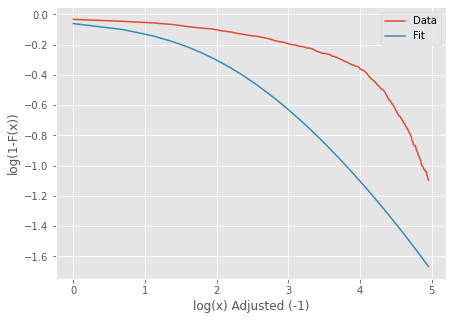


Chile
Number of positive price changes:  70755
Number of negative price changes:  50096
Percentage of positive price changes:  0.5854730204963137
Percentage of negative price changes:  0.41452697950368633
Number of days with a positive price change 730
Number of days with zero price changes  294
n_prods_pos 16573
Median positive price change:  0.07519674301147461


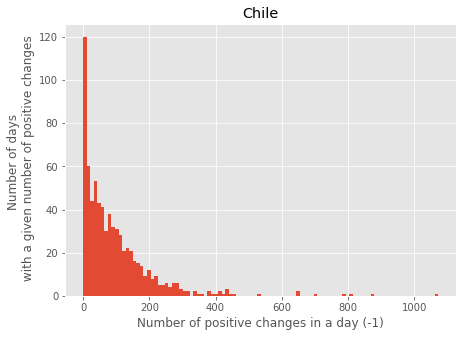

count     730.000000
mean       95.924658
std       111.813943
min         0.000000
25%        22.000000
50%        67.000000
75%       131.750000
max      1072.000000
Name: Positive_shift, dtype: float64


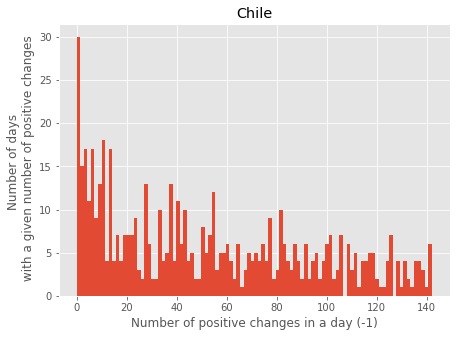

Mean/xbar is:  95.92465753424658
n is  730
Variance/ssquare:  12502.357827385982
Theta_0 moment estimator  8.402323990599855
Theta moment estimator  0.9124070472954245
Variance for Theta_0  0.22395320423774076
Variance for Theta  0.0015305815336775271
Covariance Theta_0-Theta  -0.002214687827246711
Std Error for Theta:  0.0014479941410223207
Std Error for Theta0:  0.017515285075743882
Normalized RMSE 0.10543179921471224
Optimal values of the parameters:
theta = 0.9124070472954245
theta0 = 8.402323990599855


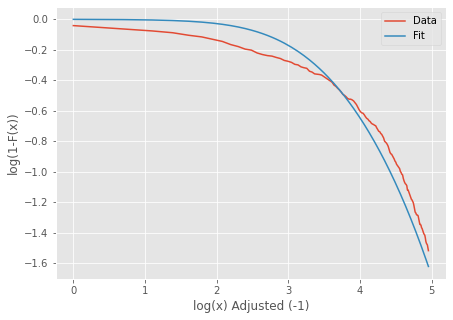


Colombia
Number of positive price changes:  47699
Number of negative price changes:  34508
Percentage of positive price changes:  0.5802303940053767
Percentage of negative price changes:  0.4197696059946233
Number of days with a positive price change 794
Number of days with zero price changes  198
n_prods_pos 7400
Median positive price change:  0.055350303649902344


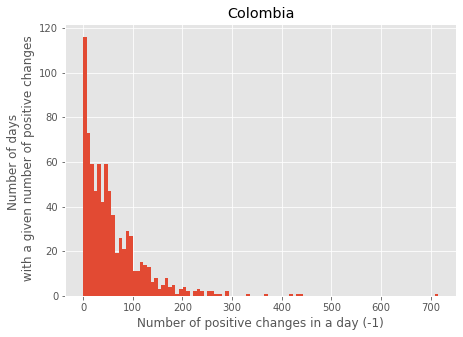

count    794.000000
mean      59.074307
std       63.992814
min        0.000000
25%       16.000000
50%       43.000000
75%       82.000000
max      715.000000
Name: Positive_shift, dtype: float64


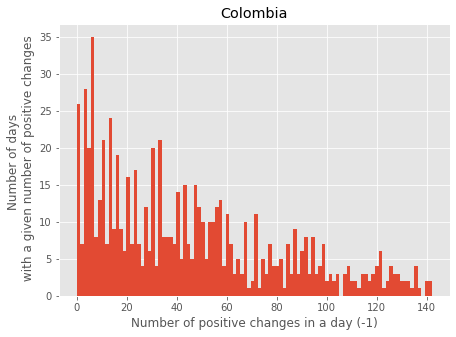

Mean/xbar is:  59.0743073047859
n is  794
Variance/ssquare:  4095.0802217768137
Theta_0 moment estimator  7.095234438431023
Theta moment estimator  0.879893057368847
Variance for Theta_0  0.12704086690420965
Variance for Theta  0.0016377681296160494
Covariance Theta_0-Theta  -0.0019992583708242483
Std Error for Theta:  0.0014362034201324207
Std Error for Theta0:  0.0126491537985315
Normalized RMSE 0.08673813599068987
Optimal values of the parameters:
theta = 0.879893057368847
theta0 = 7.095234438431023


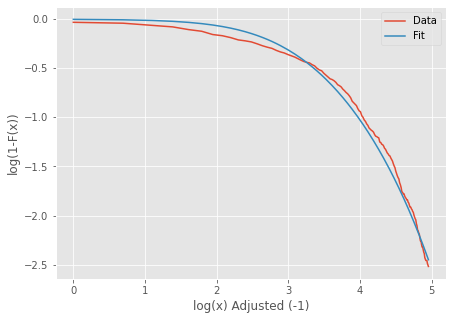

In [8]:
import statsmodels.formula.api as sm
df_estimated = pd.DataFrame(columns = ['theta', 'theta0', 
                                       'n_days', 'n_prods'], index = country)
    
for (filename,cntry) in zip(datasets,country):
    data = pd.read_stata(filename)
    print(cntry)
    
    df_estimated.loc[cntry] = data_analysis(data, cntry)
    print()
     